In [4]:
import librosa
import numpy as np
import copy
import os
from tqdm import tqdm
import pickle
from hmmlearn import hmm
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/librosa/__init__.py:35: FutureWarning: You are using librosa with Python 2. Please note that librosa 0.7 will be the last version to support Python 2, after which it will require Python 3 or later.
  FutureWarning)


In [ ]:
'''
This is the code I used to do Word Detection on clean data after Endpoint Detection.
All the endpoint detection data is saved to a folder called as Commands_Dataset.
And from there the data is loaded. The dataset folder will not be included in the submission
due to size constraints.

The following code uses Gaussian HMM with number of states = 5
'''


In [6]:
def extract_mfcc_features(filepath):
    '''
    MFCC calculator using librosa package. Also finds the delta and the delta-delta frames as a feature vector.
    '''
    y, sr = librosa.load(filepath)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc2 = librosa.feature.delta(mfcc,order=1)
    mfcc3 = librosa.feature.delta(mfcc,order=2)
    final_mfcc = np.concatenate((mfcc, mfcc2, mfcc3), axis=0)
    return final_mfcc.T

In [7]:
def buildGoogleDataSet(dir):
    '''
    Function to load data while continuously calculating the MFCC
    '''
    dataset = {}
    for f in os.listdir(dir):#os.listdir(dir)
        for w in os.listdir(dir + f):
            feature = extract_mfcc_features(dir+ f + '/' + w)
            label = f
            if label not in dataset.keys():
                dataset[label] = []
                dataset[label].append(feature)
            else:
                exist_feat = dataset[label]
                exist_feat.append(feature)
                dataset[label] = exist_feat
    return dataset

In [8]:
'''
Functions to pickle data intermediately
'''
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'w+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

In [ ]:
def train_GMMHMM(dataset):
    '''
    Function to train the data.
    num_states used is 6.
    '''
    GMMHMM_Models = {}
    states_num = 6
    for label in dataset.keys():
        model = hmm.GaussianHMM(n_components=states_num, \
                           covariance_type='full', n_iter=100)
        trainData = dataset[label]
        length = np.zeros([len(trainData), ], dtype=np.int)
        for m in range(len(trainData)):
            length[m] = trainData[m].shape[0]
        trainData = np.vstack(trainData)
        model.fit(trainData, lengths=length)  # get optimal parameters
        GMMHMM_Models[label] = model
    return GMMHMM_Models

In [ ]:
trainDir = "Commands_Dataset/train/"
trainDataSet = buildGoogleDataSet(trainDir)
print("Finish prepare the training data")


In [ ]:
hmmModels = train_GMMHMM(trainDataSet)
print("Finish training of the GMM_HMM models for 10 command words")

In [ ]:
'''
Used for saving data during long training session of around 5-6 hours
'''
#save_obj(trainDataSet, 'trainDataSet' )
#save_obj(hmmModels, 'hmmModels')

In [9]:
testDir = "Commands_Dataset/test_clean/"
testDataSet = buildGoogleDataSet(testDir)
#hmmModels = load_obj('hmmModels')

In [10]:
total_count = 0
correct_count = 0
confusion_matrix = np.zeros((10, 10))
answers = list(testDataSet.keys())
for idx,label_test in enumerate(testDataSet.keys()):
    for num in range(len(testDataSet[label_test])):
        sample = testDataSet[label_test][num]
        scoreList = {}
        for model_label in hmmModels.keys():
            model = hmmModels[model_label]
            score = model.score(sample)
            scoreList[model_label] = score
        predict = max(scoreList, key=scoreList.get)
        confusion_matrix[idx][answers.index(predict)] = confusion_matrix[idx][answers.index(predict)] + 1
        if predict == label_test:
            correct_count = correct_count+1
        total_count = total_count + 1

In [13]:
print("Accuracy: {}".format((correct_count*1.0)/total_count))

Accuracy: 0.867648327447


['on', 'right', 'off', 'no', 'stop', 'up', 'down', 'go', 'yes', 'left']


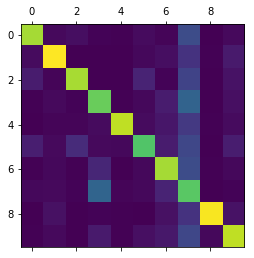

In [14]:
confusion_matrix = confusion_matrix/total_count
plt.matshow(confusion_matrix)
print(answers)

In [ ]:
'''
INFERENCE
In the above confusion matrix the rows represent the actual and columns respresent the predicted answer.
From this we can see that the word "yes" is very ambiguous. This is also because in yes 's' is dominant
and it creates a lot of confusion.
It is also evident that "go" and "no" is highly confusing words and we can see an increase in the color
corresponding to that block.

We also observed that endpointing the sound signal increases the accuracy since we are only considering
a section of the sound.
'''